# Introducton to Simulation with R
### Stephen Elston
### Data Science 350

This notebook contains a hands-on introduction to simulation methods. The R language is used to illustrate each major point.

## Introduction

Simulation enables data scientists to study the stochastic behavior of processes with complex probability distributions. Simple processes might be approximated by a know, or 'named' distributon. In these simple cases, it might even be possible to derive analytical results. However, many real-world processes have complex behavior, resulting in complex distributions of output values. In these cases, simulation is a practical approach to understanding these procecses. 

As cheap computational power has become ubiquitous, simulation has become a widely used technique in the data scientist's tool box. Simulations compute a large number of cases, or realizations, of the process being studied. The final or posterior distribution of the process being simualted is comprised of these realizations. The computing cost of each realization must be low in any practical simulation. 

Data scientists use simulation for a number of purposes:

- Simulation is used to test models. If data simulated from the model do not resemble the original data, something is like wrong with the model.
- Simulation is used to understand processes with complex distributions. In these cases, simulation provides a powerful and flexible compuational technique to understand this behavior.  

In this notebook you will create a simulation of a process with a complex distribution. 


## Creating simulations

Creating, testing annd debugging simulation software can be tricky. Some of the techniques which can make your life easier are the same as you should use when developing any analytics software, or even software in general. These techniques include:

- Build your simulation as a series of small, easily tested chunks In practice, this means you will build your simulation by creating and testing a set of small functions that comprise the overall model.
- Test each small functional unit individually. These tests should include at least testing some typical cases, as well as boundary or extreme cases. Sensible behavior with extreme or limiting cases is a requirement for a stable simulation. Both tabular and graphical output can be useful for evaluating tests.
- Test your overall simulation each time you add a new funcitonal component. This processes ensures that all the pieces work together. 
- Simulations are inherently stochastic. If you want to create identica numerical resuts, say for automated testing, set a seed before you begin tests. In this notebook no seed is set so you can experience the stochastic nature of the simulation. 


## The Scenario

The notebook implements a simulation of the profitability of a sandwich shop. Not suprisingly, the sandwich shop earns money every time a customer buys a sandwich. However, the inputs to the sandwich cost money. The daily profit is the amount customers pay for the sandwiches minus the costs of the inputs. 

The cost of bread is a particular input which is difficult to manage. TThe shop bakes its own bread, and the bread must be used on the day it is made. The customers can select one of three types of bread, wheat, and multigrain. If the shop does not have sufficient bread of the customer's choice on hand, the customer will leave the shop without buying a sandwich. However, any extra bread left at the end of the day is discarded and the cost reduces the profitability of the shop. 

To keep the simulation simple, several assumptions are made:

- The probability that each customer chooses a particular type of bread is fixed and known. There probabilities are 50% for white bread, 25% for wheat and 25% for multigrain. 
- If a customer's choice of bread is not available the customer leaves the shop without buying a sandwich.
- The only perishable input which must be discarded at the end of each day is the bread. 

## Realizations of Distribution

The ability to compute large numbers of realizations from probabilitie distributions is fundamental to simulation. Two questions natuarally arrise. 

- Which distribution to choose? The answer to this question is typically determined through domain knowledge. Even so, there  may be several choices which can be tested and  compaired.
- How many realizations are required? The answer will depend on the accuracy you require from your simulation. Typically, some tests will indicate an appropriate number of realizations.

For arrival processes, Poisson distributions are typically used. However, if the arrival rate is fairly high, the difference between a Poisson distribution and an approprate Normal distribution will be minimal. 

Warning message:
"Removed 1 rows containing missing values (geom_bar)."Warning message:
"Removed 1 rows containing missing values (geom_bar)."

TableGrob (2 x 1) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]


      norm            poiss       
 Min.   : 58.82   Min.   : 74.00  
 1st Qu.: 92.10   1st Qu.: 93.00  
 Median : 99.35   Median : 99.50  
 Mean   : 99.16   Mean   : 99.69  
 3rd Qu.:105.51   3rd Qu.:106.00  
 Max.   :125.93   Max.   :118.00  

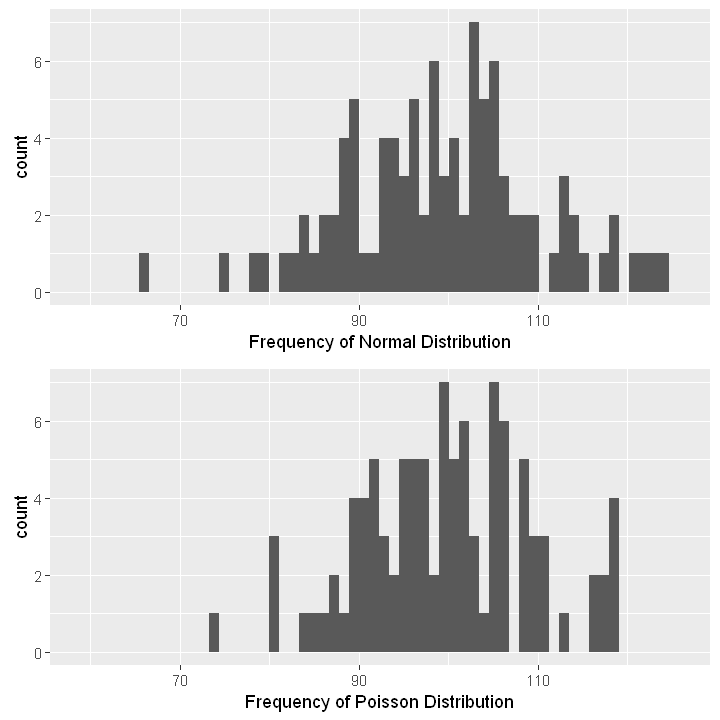

In [24]:
dist.plot = function(n, mu = 100, sigma = 10){
    require(ggplot2)
    require(gridExtra)
    require(repr)
    options(repr.plot.width=6, repr.plot.height=6)
    dists = data.frame(
        norm = rnorm(n, mu, sigma),
        poiss = rpois(n, mu))
    minx = min(min(dists$norm), min(dists$poiss))
    maxx = max(max(dists$norm), max(dists$poiss))
    bw = (maxx - minx) / 60
    p1 = ggplot(dists, aes(norm)) + geom_histogram(binwidth = bw) + 
                xlab('Frequency of Normal Distribution') + 
                xlim(minx, maxx)
    p2 = ggplot(dists, aes(poiss)) + geom_histogram(binwidth = bw) +
                xlab('Frequency of Poisson Distribution')  + 
                xlim(minx, maxx)
    print(grid.arrange(p1, p2, nrow = 2))
    summary(dists)
}
dist.plot(100)

**Your Turn:** To develop a feeling for how the Normal and  Poisson distributions change with number of realizations and the expected value, in the cells below try the following:

- Using the R `lappy` function compute the summary statistics and plot the Normal and Poisson distribtutions with an expected value of 100 and 1000, 10000, and 100000 realizations.
- Using the R `Map` function (use `?Map` if you don't know how this works), plot the Normal and Poisson distributions with 100000 realizations and expected values of 600, 300 and 100.

## Simulate Demand

In order to develop an overall profitability model the demand must be simulated. To simulate demand you must first simulate the number of arrivals and then the demand for each type of bread given the arrivals. 

The demand for bread on a given day is sumulated with the code in the cell below. Given the number of arrivals `n`, the `sim.demand` function computes the numbers of each type of bread required. The last line of code in the the cell tests the function for one realization. Run this code and examine the result.

In [30]:
sim.bread = function(n){
  bread = runif(n) # Probabilities of bread choice 
  ifelse(bread <= 0.5, 'white', 
         ifelse(bread <= 0.75, 'wheat', 'multi'))
}

table(sim.bread(100))


multi wheat white 
   26    26    48 

Examine the table of demand by type of bread. Notice that the proportions of white, wheat and muligrain are approximately 2, 1, 1, respectively. 


You can now compute the dread demand for one realization of arrivals. Next, you must simulate realizaitons of arrivals of people at the sandwich shop. Often arrival rates, k, per time interval are modeled as a Poisson process with rate or intesity $\lambda$, which can be written:

$$P(k\ arrivals\ per\ interval) = \frac{\lambda^k\ e^{-\lambda}}{k!}$$

The demand for bread is clealy dependent on the number of arrivals, as well as the probability that customers choose each type of bread. In other words, what you need to compute is the conditional distribuion of bread demand given arrivals, or $P(bread\ |\ arrivals)$.

The code in the cell below performs the following operations:

- The distribution of the arrivals in computed by realizations of a Poisson distribution.
- A matrix is created to hold  the demand for each bread type for each realization of the arrivals.
- Loop over the realizations of the arrivals, compute the demand for each bread type, and save the results in a row of the matrix.

Execute this code and  examine the results.

In [31]:
sim.demand = function(lambda, n){
    arrivals = rpois(n, lambda)  # Compute realizations of arrivals
    demand.mat = matrix(0, n, 3) # Initalize a matrix
    i = 1
    for (a in arrivals) {
        demand.mat[i, ] = t(matrix(table(sim.bread(a)))) # Add one realization to matrix
        i = i + 1
    }   
    demand = data.frame(demand.mat)
    names(demand) = c('multigrain', 'wheat', 'white')
    demand
} 
sim.demand(100, 10)

multigrain,wheat,white
24,27,37
31,27,46
26,20,54
18,26,51
21,25,58
29,29,46
17,25,47
17,32,53
20,23,42
28,20,57


In [32]:
baked.bread = function(n){
    baked = c(rep('white', times =n/2), 
             rep('wheat', times = n/4),
             rep('multi', times =n/4))
    baked = data.frame(table(baked))[, 2]
    names(baked) = c('multigrain', 'wheat', 'white')
    t(baked)
}
baked.bread(12)

multigrain,wheat,white
3,3,6


In [33]:
sim.profit = function(n, lambda, earned, baked, cost){
    bread = baked.bread(baked) # Amount of bread baked
    demand = sim.demand(lambda, n) # Demand by type of bread
    profit = matrix(0, n, 1) # Empty matrix for results
    for (i in 1:3){  # Loop over each type of bread
        temp = bread[i] - demand[, i]
        profit = ifelse(temp >= 0,  # Did we have enough bread of this type?
                        profit + earned * demand[, i] - cost * bread[i], # If yes, compute profit
                        profit + (earned - cost) * bread[i]) # If no, limited by available bread
    }
    data.frame(profit = profit, demand = demand, bread = bread)
}
sim.profit(10, 100, 1.00, 100, .25)

profit,demand.multigrain,demand.wheat,demand.white,bread.multigrain,bread.wheat,bread.white
70,23,30,47,25,25,50
58,24,19,40,25,25,50
74,39,24,59,25,25,50
70,23,23,49,25,25,50
59,15,27,44,25,25,50
69,19,28,51,25,25,50
73,27,33,48,25,25,50
64,20,19,65,25,25,50
65,20,29,45,25,25,50
64,29,29,39,25,25,50


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


TableGrob (2 x 1) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]


     profit           demand      
 Min.   :-59.00   Min.   : 66.00  
 1st Qu.:-32.00   1st Qu.: 93.00  
 Median :-25.00   Median :100.00  
 Mean   :-25.08   Mean   : 99.92  
 3rd Qu.:-18.00   3rd Qu.:107.00  
 Max.   : 17.00   Max.   :142.00  

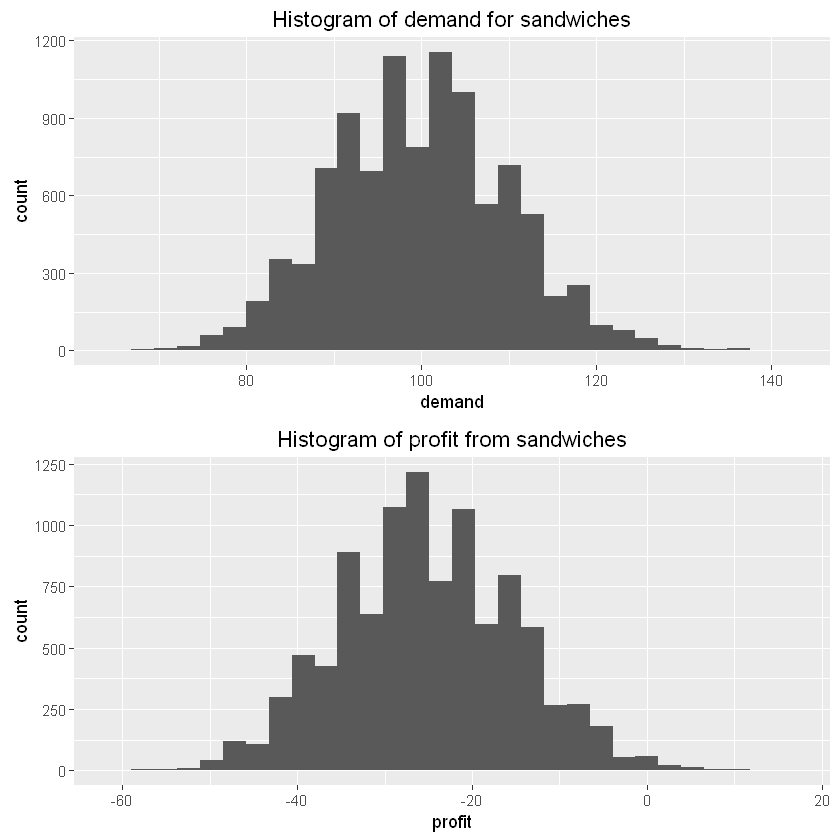

In [36]:
plot.demand = function(demand){
    require(ggplot2)
    require(gridExtra)
    demand$demand = apply(demand[, 2:4], 1, sum) # Compute the total demand
    p1 = ggplot(demand, aes(demand)) + geom_histogram() +
         ggtitle('Histogram of demand for sandwiches')
    p2 = ggplot(demand, aes(profit)) + geom_histogram() +
         ggtitle('Histogram of profit from sandwiches')
    print(grid.arrange(p1, p2, nrow = 2))
    summary(demand[, c(1, 8)])
}
demand = sim.profit(10000, 100, 1.00, 500, .25)
plot.demand(demand)

#### Copyright 2017, Stephen F Elston. All rights reserved.